In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

In [28]:
# Performance vintage
start_date = (datetime.today() - timedelta(days=500)).strftime('%Y-%m-%d')
end_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
print(f'start date: {start_date}, end date : {end_date}')

start date: 2021-06-08, end date : 2022-10-20


In [29]:
# Daily return for stock selections
tickers = ['NIO','DDOG','DG','FUTU','OXY']
price_data = web.get_data_yahoo(tickers,
                           start = start_date,
                           end = end_date)['Adj Close']

log_ret = np.log(price_data/price_data.shift(1))

log_ret.head()

Symbols,NIO,DDOG,DG,FUTU,OXY
Date,,,,,
2021-06-08,NaN,NaN,NaN,NaN,NaN
2021-06-09,-0.019004,-0.008252,-0.003848,-0.056121,-0.028857
2021-06-10,0.000468,0.029859,0.007390,-0.010835,-0.000706
2021-06-11,0.066058,0.010317,0.013758,0.009186,0.000000
2021-06-14,0.018866,0.018368,0.001146,0.063722,-0.001766


In [30]:
# Covariance matrix
cov_mat = log_ret.cov() * 252
print(cov_mat)

Symbols       NIO      DDOG        DG      FUTU       OXY
Symbols                                                  
NIO      0.612990  0.246103  0.033876  0.458012  0.070066
DDOG     0.246103  0.428357  0.042626  0.206386  0.054362
DG       0.033876  0.042626  0.076485  0.032109  0.019956
FUTU     0.458012  0.206386  0.032109  0.780072  0.037464
OXY      0.070066  0.054362  0.019956  0.037464  0.301032


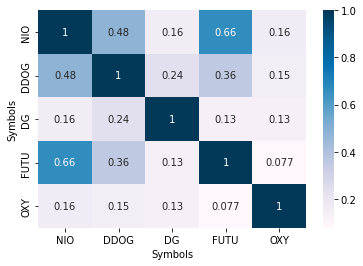

In [32]:
# Correlation plot
cor = log_ret.corr()
sns.heatmap(cor, annot=True,cmap=plt.cm.PuBu);

In [33]:
# We find the frontier as shown below and either maximize the Expected Returns for Risk level or minimize Risk for a given Expected Return level.

In [34]:
# Simulating 5000 portfolios
# Trial and error
num_port = 5000
# Creating an empty array to store portfolio weights
all_wts = np.zeros((num_port, len(price_data.columns)))
# Creating an empty array to store portfolio returns
port_returns = np.zeros((num_port))
# Creating an empty array to store portfolio risks
port_risk = np.zeros((num_port))
# Creating an empty array to store portfolio sharpe ratio
sharpe_ratio = np.zeros((num_port))

for i in range(num_port):
  wts = np.random.uniform(size = len(price_data.columns))
  wts = wts/np.sum(wts)
  
  # saving weights in the array  
  all_wts[i,:] = wts
  
  # Portfolio Returns
  port_ret = np.sum(log_ret.mean() * wts)
  port_ret = (port_ret + 1) ** 252 - 1
  
  # Saving Portfolio returns 
  port_returns[i] = port_ret
  
  # Portfolio Risk
  port_sd = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts)))
  port_risk[i] = port_sd
  
  # Portfolio Sharpe Ratio
  # Assuming 0% Risk Free Rate
  
  sr = port_ret / port_sd
  sharpe_ratio[i] = sr

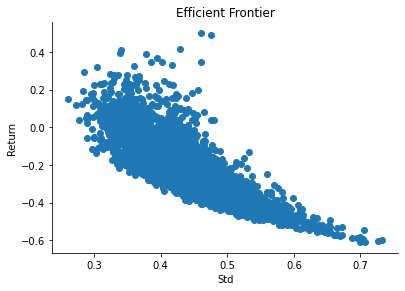

In [35]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Std')
ax1.set_ylabel("Return")
ax1.set_title("Efficient Frontier")
plt.scatter(port_risk, port_returns)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [36]:
# Minimum variance portfolio  
names = price_data.columns
min_var = all_wts[port_risk.argmin()]

print("The min variance", round(port_risk.min(),5)) 
dict(zip(tickers, min_var.tolist()))

The min variance 0.26138


{'NIO': 0.03094250450270775,
 'DDOG': 0.05815672997869761,
 'DG': 0.6493417929561902,
 'FUTU': 0.036690717172130856,
 'OXY': 0.22486825539027372}

In [37]:
# The Sharpe-ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
# Max sharpe ratio portfolio
max_sr = all_wts[sharpe_ratio.argmax()]
print("The max sharpe ratio", round(sharpe_ratio.max(),2))
dict(zip(tickers, max_sr.tolist()))

The max sharpe ratio 1.2


{'NIO': 0.02551273802184155,
 'DDOG': 0.07782451041880657,
 'DG': 0.36602634584885535,
 'FUTU': 0.0004328647524680093,
 'OXY': 0.5302035409580287}

In [38]:
# Track portfolio peformance
# Performance vintage
start_date = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')
end_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')

# Stock weights using max sharpe ratio
wts = max_sr.tolist()

price_data = web.get_data_yahoo(tickers,
                               start = start_date,
                               end = end_date)

In [39]:
# Stock monthly return
ret_data = price_data['Adj Close'].resample('M').ffill().pct_change()
ret_data.head()

Symbols,NIO,DDOG,DG,FUTU,OXY
Date,,,,,
2021-10-31,NaN,NaN,NaN,NaN,NaN
2021-11-30,-0.007105,0.067285,-0.000993,-0.112668,-0.115717
2021-12-31,-0.190391,-0.001010,0.065657,-0.088229,-0.021942
2022-01-31,-0.226326,-0.179664,-0.114396,-0.001155,0.299414
2022-02-28,-0.068135,0.102662,-0.048638,-0.011561,0.160871


In [40]:
# Portflio monthly return
port_ret = (ret_data * wts).sum(axis = 1)[1:]
port_ret.head()

Date
2021-11-30   -0.056711
2021-12-31    0.007425
2022-01-31    0.097121
2022-02-28    0.073738
2022-03-31    0.197448
Freq: M, dtype: float64

In [41]:
# Benchmark to S&P 500 etf 
benchmark_price = web.get_data_yahoo('SPY',
                               start = start_date,
                               end = end_date)      

benchmark_ret = benchmark_price['Adj Close'].resample('M').ffill().pct_change()[1:]
benchmark_ret.head()

Date
2021-11-30   -0.008035
2021-12-31    0.046248
2022-01-31   -0.052741
2022-02-28   -0.029517
2022-03-31    0.037590
Freq: M, Name: Adj Close, dtype: float64

/opt/anaconda3/envs/coursera/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


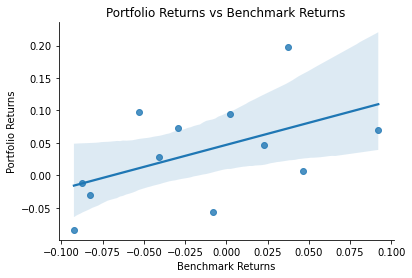

In [43]:
sns.regplot(benchmark_ret.values,port_ret.values)
plt.xlabel("Benchmark Returns")
plt.ylabel("Portfolio Returns")
plt.title("Portfolio Returns vs Benchmark Returns")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [45]:
# Beta and Alpha
(beta, alpha) = stats.linregress(benchmark_ret.values,
                port_ret.values)[0:2]
                
print("The portfolio beta is", round(beta, 4))
print("The portfolio alpha is", round(alpha,5))

print("Portfolio average monthly return:", port_ret.mean())
print("Portfolio average monthly std:",port_ret.std())

The portfolio beta is 0.6798
The portfolio alpha is 0.04711
Portfolio average monthly return: 0.03620040300795601
Portfolio average monthly std: 0.07779312515561052
